# DEFINE GOOGLE COLAB FLAG!

In [2]:
isGoogleColab = True

# Notes

- check these blog posts: https://muellerzr.github.io/fastblog/ and his course: https://walkwithfastai.com/intro.contribute
- learner.export() already save all the transforms that will be applied during inference time, so it is not necessary to resize or normalize stats. If running outside the model outside fastai, check: https://forums.fast.ai/t/do-we-need-to-normalize-single-image-before-running-predict-function-on-it/44301/4
- to_fp16() is mixed precision
- item_tfms already apply the resize before collating the images in a batch. So it is not necessary to do this manually
- aug_tfms will only be applied on train_dl. validation and test will not be affected
- test_dl is a testing dataloader that uses the same transforms as train_dl and valid_dl, but with new data
- check images cleaner in the future
- cross validation: check walkwithfastai video 3 or https://forums.fast.ai/t/is-it-possible-to-implement-cross-validation-in-fastai/44961/15



# Installation

## Kill all other GPU sessions

Run the first time this cell. Then, restart your session and run again the notebook without this code.

In [ ]:
  #!kill -9 -1

## Update ipython/ipykernel (Colab)

The Colab session can fail when running the first time this cell. Just run it a second time.

In [ ]:
# This magic cell should be put first in your colab notebook. 
# It'll automatically upgrade colab's really antique ipython/ipykernel to their 
# latest versions which are required for packages like ipyexperiments 
# from packaging import version
# import IPython, ipykernel
# IPython.__version__
# if version.parse(IPython.__version__) <= version.parse("5.5.0"):
#     !pip install -q --upgrade ipython
#     !pip install -q --upgrade ipykernel
    
#     import os
#     import signal
#     os.kill(os.getpid(), signal.SIGTERM)
# print(f"ipykernel=={ipykernel.__version__}")
# print(f"IPython=={IPython.__version__}")

In [ ]:
# new (large)
# !pip install ipyexperiments
# new (large)
# from ipyexperiments import IPyExperimentsPytorch
# exp = IPyExperimentsPytorch()

## Check GPU e CPU RAM

In [3]:
if isGoogleColab:
    
    import torch
    from pynvml import *
    nvmlInit()
    def log_mem():
        h = nvmlDeviceGetHandleByIndex(0)
        info = nvmlDeviceGetMemoryInfo(h)
        print(f'GPU total Memory    : {info.total}')
        print(f'GPU free Memory     : {info.free}')
        print(f'GPU Memory used     : {info.used}')
    torch.ones(1).to(0)
    log_mem()

GPU total Memory    : 11996954624
GPU free Memory     : 11526799360
GPU Memory used     : 470155264


## Mount the Google Drive to Google Colab

In [4]:
if isGoogleColab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    path_to_drive = "/content/drive/MyDrive/Colab Notebooks/"
    sys.path.append(path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/') #make src files importable

else:
    path_to_drive = "./"

Mounted at /content/drive


## Install Deep Learning libraries

In [ ]:
# !pip install torch==1.9.0
# !pip install fastai==2.5.0
# !pip install wandb

In [7]:
import sys; print('Python:',sys.version)
import torch; print('Pytorch:',torch.__version__)
import fastai; print('Fastai:',fastai.__version__)

Python: 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Pytorch: 1.9.0+cu102
Fastai: 1.0.61


# Train your model

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.callback.wandb import *
import torch
import torchvision
from PIL import Image
import wandb
wandb.login()

ModuleNotFoundError: ignored

## Data

In [ ]:
path = path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/' 
path_anno = path + 'gt/'
path_img = path + 'done/'

#funcao que pega a imagem de anotacoes correspondente, dado a imagem original de entrada
get_y_fn = lambda x : path_anno + '/' + f'{x.stem}_GT.png'

In [ ]:
np.random.seed(2) #mesma semente para todas as vezes que executar

label_fnames = get_image_files(path_anno)
print(label_fnames[:3])
fnames = get_image_files(path_img)
print(fnames[:3])

codes = np.loadtxt(path + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf')
codesId = [code.split(": ")[0] for code in codes]
codes = [code.split(": ")[1] for code in codes] #pega apenas o nome de cada classe e ignora o ID
len(fnames), len(codes)

[Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/gt/136_GT.png'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/gt/570_GT.png'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/gt/900_GT.png')]
[Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/done/176.jpg'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/done/976.jpg'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/done/469.jpg')]


(431, 5)

In [ ]:
### fix GT ids: masks must be [0, 1, …, K-1] where K is the number of categories

def createAdjustedGroundTruthIds(fnames):
  "Gather the codes from a list of `fnames`"
  vals = set()
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(sorted(vals))

  for i,val in enumerate(vals):
    adjustedGroundTruthIds[i] = vals[i]

def get_y_fn(item):
  "Grab a mask from a `filename` and adjust the pixels based on `adjustedGroundTruthIds`"
  itemGtPath = path_anno + '/' + f'{item.stem}_GT.png'
  msk = np.array(PILMask.create(itemGtPath))
  mx = np.max(msk)
  for i, val in enumerate(adjustedGroundTruthIds):
    msk[msk==adjustedGroundTruthIds[i]] = val
  return PILMask.create(msk)

adjustedGroundTruthIds = dict()
adjustedGroundTruthIds = {i : int(codesId[i]) for i in range(len(codes))}
# createAdjustedGroundTruthIds(label_fnames)

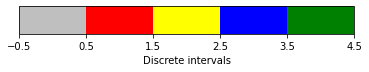

In [ ]:
# define colormap for masks

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = matplotlib.colors.ListedColormap([np.random.rand(3,) for i in range(0,len(codes))])
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.75, .75, .75, 1.0) # nao alimento -> cinza
cmaplist[1] = "red" # nao registrado
cmaplist[2] = "yellow" #arroz integral
cmaplist[3] = "blue" #arroz branco
cmaplist[4] = "green" #feijao

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = [i-0.5 for i in range(0,len(codes)+1)] # intervalos devem conter apenas o numero inteiro, entao ir de 0.5 em 0.5
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

cb2 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Discrete intervals')
fig.show()

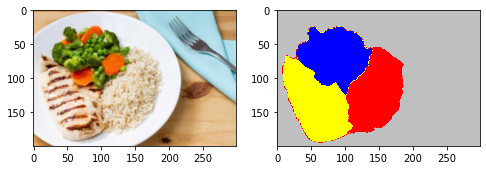

Ground truth Codes [0 1 2 3]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/done/176.jpg


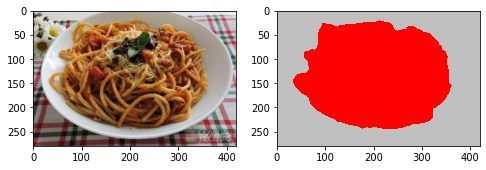

Ground truth Codes [0 1]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/done/976.jpg


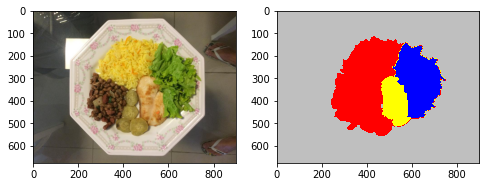

Ground truth Codes [0 1 2 3]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/done/469.jpg


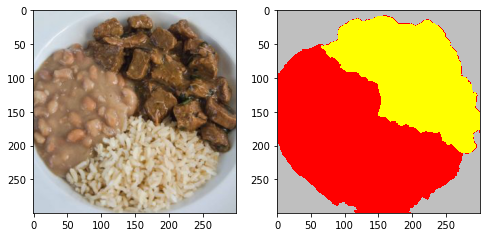

Ground truth Codes [0 1 2]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/done/165.jpg


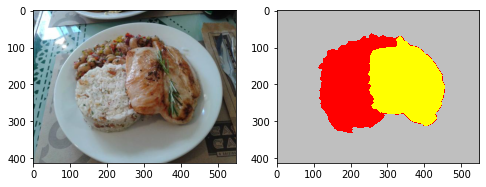

Ground truth Codes [0 1 2]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/done/643.jpg


In [ ]:
### VISUALIZACAO DA MÁSCARA FICA COM A BORDA ESTRANHA, MAS ELA ESTÁ CORRETA COMO PODE SER VISTO NOS CODIGOS DO GROUND TRUTH

for idx in range(0,5):
  fig = plt.figure(figsize=(8,8))

  img = Image.open(fnames[idx])
  arr = np.asarray(img)
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(arr)

  img1 = get_y_fn(fnames[idx]) # use this when 'adjustedGroundTruthIds' is necessary
  # img1 = Image.open(get_y_fn(fnames[idx]))
  arr = np.asarray(img1)
  ax1 = fig.add_subplot(1,2,2)
  ax1.imshow(arr, cmap=cmap, norm=norm)
  plt.show()

  print("Ground truth Codes", np.unique(arr,return_counts=False))
  print(fnames[idx])


## Cross Validation Training

In [ ]:
# get test data

import pickle
with open(path + "testFilenamesSprint0.pkl", 'rb') as f:
  testFiles = pickle.load(f)
X_test = [file for file in fnames if file.name in testFiles]
len(X_test)

87

In [ ]:
# init kfold class

from kfoldTraining import KFoldTraining

folds = 5
kfold = KFoldTraining("sprint5-resnet101", path, fnames, get_y_fn, codes, kFolds=folds, X_test=X_test,isGoogleColab=isGoogleColab)

Training and Validation dataset size: 344
Test dataset size: 87


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Tr

Length of trainingset 275
Length of validationset 69
Length of testset 87


Better model found at epoch 0 with miou value: 0.37588155086587977.


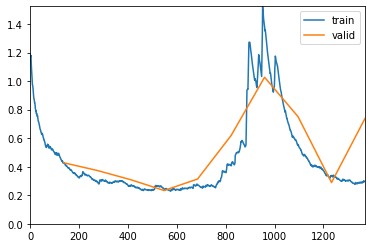

Better model found at epoch 1 with miou value: 0.42648783668426654.
Better model found at epoch 2 with miou value: 0.4786383325642367.


Better model found at epoch 0 with miou value: 0.39510561198864497.


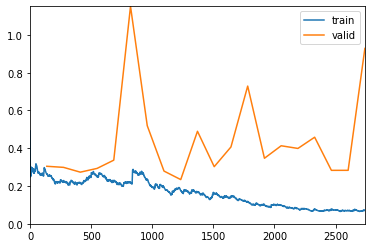

Better model found at epoch 1 with miou value: 0.48162691138340163.
Better model found at epoch 2 with miou value: 0.5063599515211762.
Better model found at epoch 6 with miou value: 0.5245652827361821.
Better model found at epoch 7 with miou value: 0.5424965964720397.
Better model found at epoch 11 with miou value: 0.559097002638674.
Better model found at epoch 13 with miou value: 0.5755436938485239.
Better model found at epoch 16 with miou value: 0.5758337791337166.


Length of trainingset 275
Length of validationset 69
Length of testset 87


Better model found at epoch 0 with miou value: 0.3451577491908506.


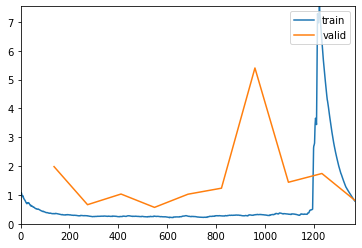

Better model found at epoch 1 with miou value: 0.42249103746957195.
Better model found at epoch 2 with miou value: 0.43886312847917264.
Better model found at epoch 4 with miou value: 0.45389637926428605.


Better model found at epoch 0 with miou value: 0.4649511484833228.


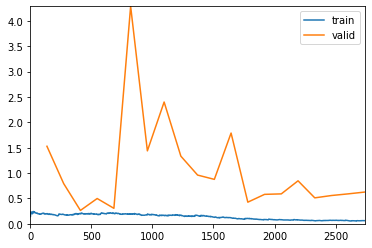

Better model found at epoch 4 with miou value: 0.4807910140710274.
Better model found at epoch 5 with miou value: 0.5090058551403998.
Better model found at epoch 9 with miou value: 0.5141727931672422.
Better model found at epoch 10 with miou value: 0.553138933903498.
Better model found at epoch 12 with miou value: 0.5734539049005284.
Better model found at epoch 13 with miou value: 0.5898744339312336.
Better model found at epoch 16 with miou value: 0.5944872476581574.


Length of trainingset 275
Length of validationset 69
Length of testset 87


Better model found at epoch 0 with miou value: 0.33772215328752553.


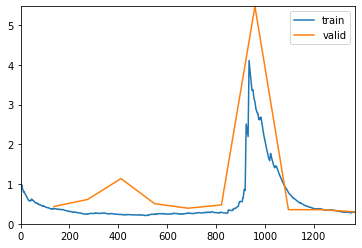

Better model found at epoch 2 with miou value: 0.3430647871260114.
Better model found at epoch 4 with miou value: 0.35041152274693554.


Better model found at epoch 0 with miou value: 0.44682177235662734.


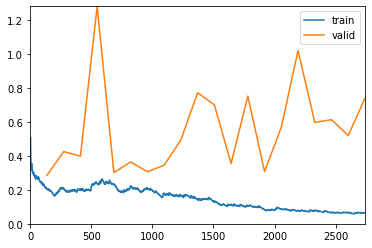

Better model found at epoch 6 with miou value: 0.4554321013927728.
Better model found at epoch 9 with miou value: 0.47674740904975504.
Better model found at epoch 10 with miou value: 0.49796051878906633.
Better model found at epoch 11 with miou value: 0.5189663582394286.
Better model found at epoch 14 with miou value: 0.5212699707241588.
Better model found at epoch 18 with miou value: 0.5215372403363446.


Length of trainingset 275
Length of validationset 69
Length of testset 87


Better model found at epoch 0 with miou value: 0.35862326038692516.


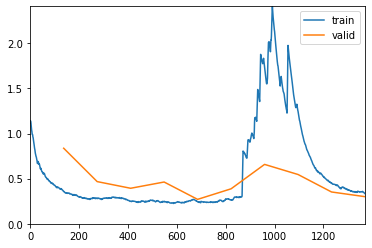

Better model found at epoch 2 with miou value: 0.48062301885733416.


Better model found at epoch 0 with miou value: 0.4911691661663405.


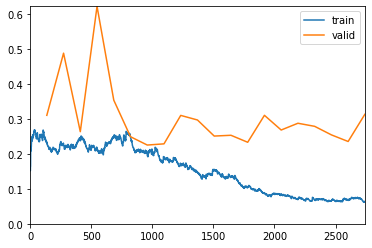

Better model found at epoch 1 with miou value: 0.4925433341548728.
Better model found at epoch 2 with miou value: 0.49485149607833545.
Better model found at epoch 7 with miou value: 0.502705128629988.
Better model found at epoch 8 with miou value: 0.5311270234701547.
Better model found at epoch 11 with miou value: 0.5433324512105814.
Better model found at epoch 12 with miou value: 0.5937180470640718.


Length of trainingset 276
Length of validationset 68
Length of testset 87


Better model found at epoch 0 with miou value: 0.4045360934788421.


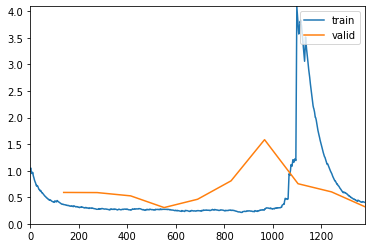

Better model found at epoch 2 with miou value: 0.4177959026850826.
Better model found at epoch 3 with miou value: 0.46212279115808286.
Better model found at epoch 4 with miou value: 0.4689504959871565.
Better model found at epoch 6 with miou value: 0.48366698191524676.


Better model found at epoch 0 with miou value: 0.4997664684412567.


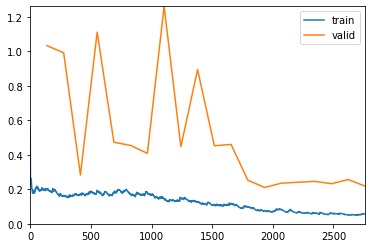

Better model found at epoch 1 with miou value: 0.5512508234333157.
Better model found at epoch 7 with miou value: 0.5588918885876331.
Better model found at epoch 10 with miou value: 0.5822092854585221.
Better model found at epoch 16 with miou value: 0.5902588276230848.


In [ ]:
# training

from torchvision.models import ResNet,resnet18,resnet34,resnet50,resnet101,resnet152
from torchvision.models import SqueezeNet,squeezenet1_0,squeezenet1_1
from torchvision.models import densenet121,densenet169,densenet201,densenet161
from torchvision.models import vgg11_bn,vgg13_bn,vgg16_bn,vgg19_bn,alexnet

validation_metrics, test_metrics = kfold.train(bs=2, gradientAcc=8, lr=5e-4, freezeEpochs=10, unfreezeEpochs=20, backbone=resnet101)

In [ ]:
# print metrics

print("\tLoss","\t\tAcc_segmentation","\tDiceMulti","\t\tmIOU")

val_mean = [0,0,0,0]
test_mean = [0,0,0,0]
for val_metric, test_metric in zip(validation_metrics, test_metrics):
    print("\nValidation Metrics")
    print(val_metric)
    print("Test Metrics")
    print(test_metric)

    val_mean = [x + y for (x, y) in zip(val_mean, val_metric)]
    test_mean = [x + y for (x, y) in zip(test_mean, test_metric)]

val_mean = [x / folds for x in val_mean]
test_mean = [x / folds for x in test_mean]
print("\nMean Validation Metrics")
print(val_mean)
print("Mean Test Metrics")
print(test_mean)

	Loss 		Acc_segmentation 	DiceMulti 		mIOU

Validation Metrics
[0.45845192670822144, 0.7880110740661621, 0.7140773327408764, 0.5758337791337166]
Test Metrics
[0.8032956123352051, 0.7684354186058044, 0.7360442876443443, 0.6018929904541477]

Validation Metrics
[0.5114259123802185, 0.7197505831718445, 0.7257114734834986, 0.5944872476581574]
Test Metrics
[0.3037130534648895, 0.7876223921775818, 0.7562780686450918, 0.6237535674759564]

Validation Metrics
[0.5187999606132507, 0.7148317694664001, 0.6918658152099697, 0.5215372403363446]
Test Metrics
[0.5420725345611572, 0.782202422618866, 0.725389804741759, 0.5829441641304091]

Validation Metrics
[0.23350757360458374, 0.7720288038253784, 0.7307626477201026, 0.5937180470640718]
Test Metrics
[0.2079499512910843, 0.7937523126602173, 0.7325218135119259, 0.5958885211566978]

Validation Metrics
[0.24596913158893585, 0.7912869453430176, 0.7229348941065241, 0.5902588276230848]
Test Metrics
[0.2342599630355835, 0.7934767603874207, 0.7361334248969639, 0

In [ ]:
while True: pass

## FastAI Validation

In [ ]:
id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id

# LOAD ONLY IF NECESSARY
# learner = unet_learner(dataloaders, resnet34, metrics=metrics)
# learner.load('stage-2-best')

In [ ]:
print(learner.validate(dl=test_dl))

NameError: ignored

In [ ]:
learner.show_results(dl=test_dl, figsize=(15,15), max_n=20, cmap=cmap, norm=norm,alpha=0.8)

In [ ]:
interp = Interpretation.from_learner(learner, dl=test_dl)

In [ ]:
losses,idxs = interp.top_losses()
interp.plot_top_losses(2, figsize=(15,11), cmap=cmap)

In [ ]:
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
#interp.most_confused(min_val=10)

## Sklearn Validation

In [ ]:
from sklearnMetrics import Metrics
void_code = 0
metricsObject = Metrics(codes, [void_code])
id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id

# LOAD ONLY IF NECESSARY
# learner = unet_learner(dataloaders, resnet34, metrics=metrics)
# learner.load('stage-2-best')

C:\Users\bruno\miniconda3\lib\site-packages\fastai\learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
input, probabilities, groundTruth, decoded, losses = learner.get_preds(dl=test_dl,  with_input=True, with_loss=True, with_decoded=True, act=F.softmax) 

C:\Users\bruno\miniconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=range(1, 117) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
c:\Users\bruno\Documents\diabetesLearning\diabeteslearningDeeplearning\notebooks\tcc\fastaiMetrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  iou_index = per_class_TP / (per_class_TP + per_class_FP + per_class_FN)
C:\Users\bruno\miniconda3\lib\site-packages\torch\tensor.py:995: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ret = func(*args, **kwargs)


In [ ]:
print(metricsObject.getAccuracy(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

0.26330192015004533


In [ ]:
print(metricsObject.get_f1Score(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

0.27329683152320255


In [ ]:
confusionMatrix = metricsObject.getConfusionMatrix(decoded.flatten().numpy(), groundTruth.flatten().numpy(), plot=False)

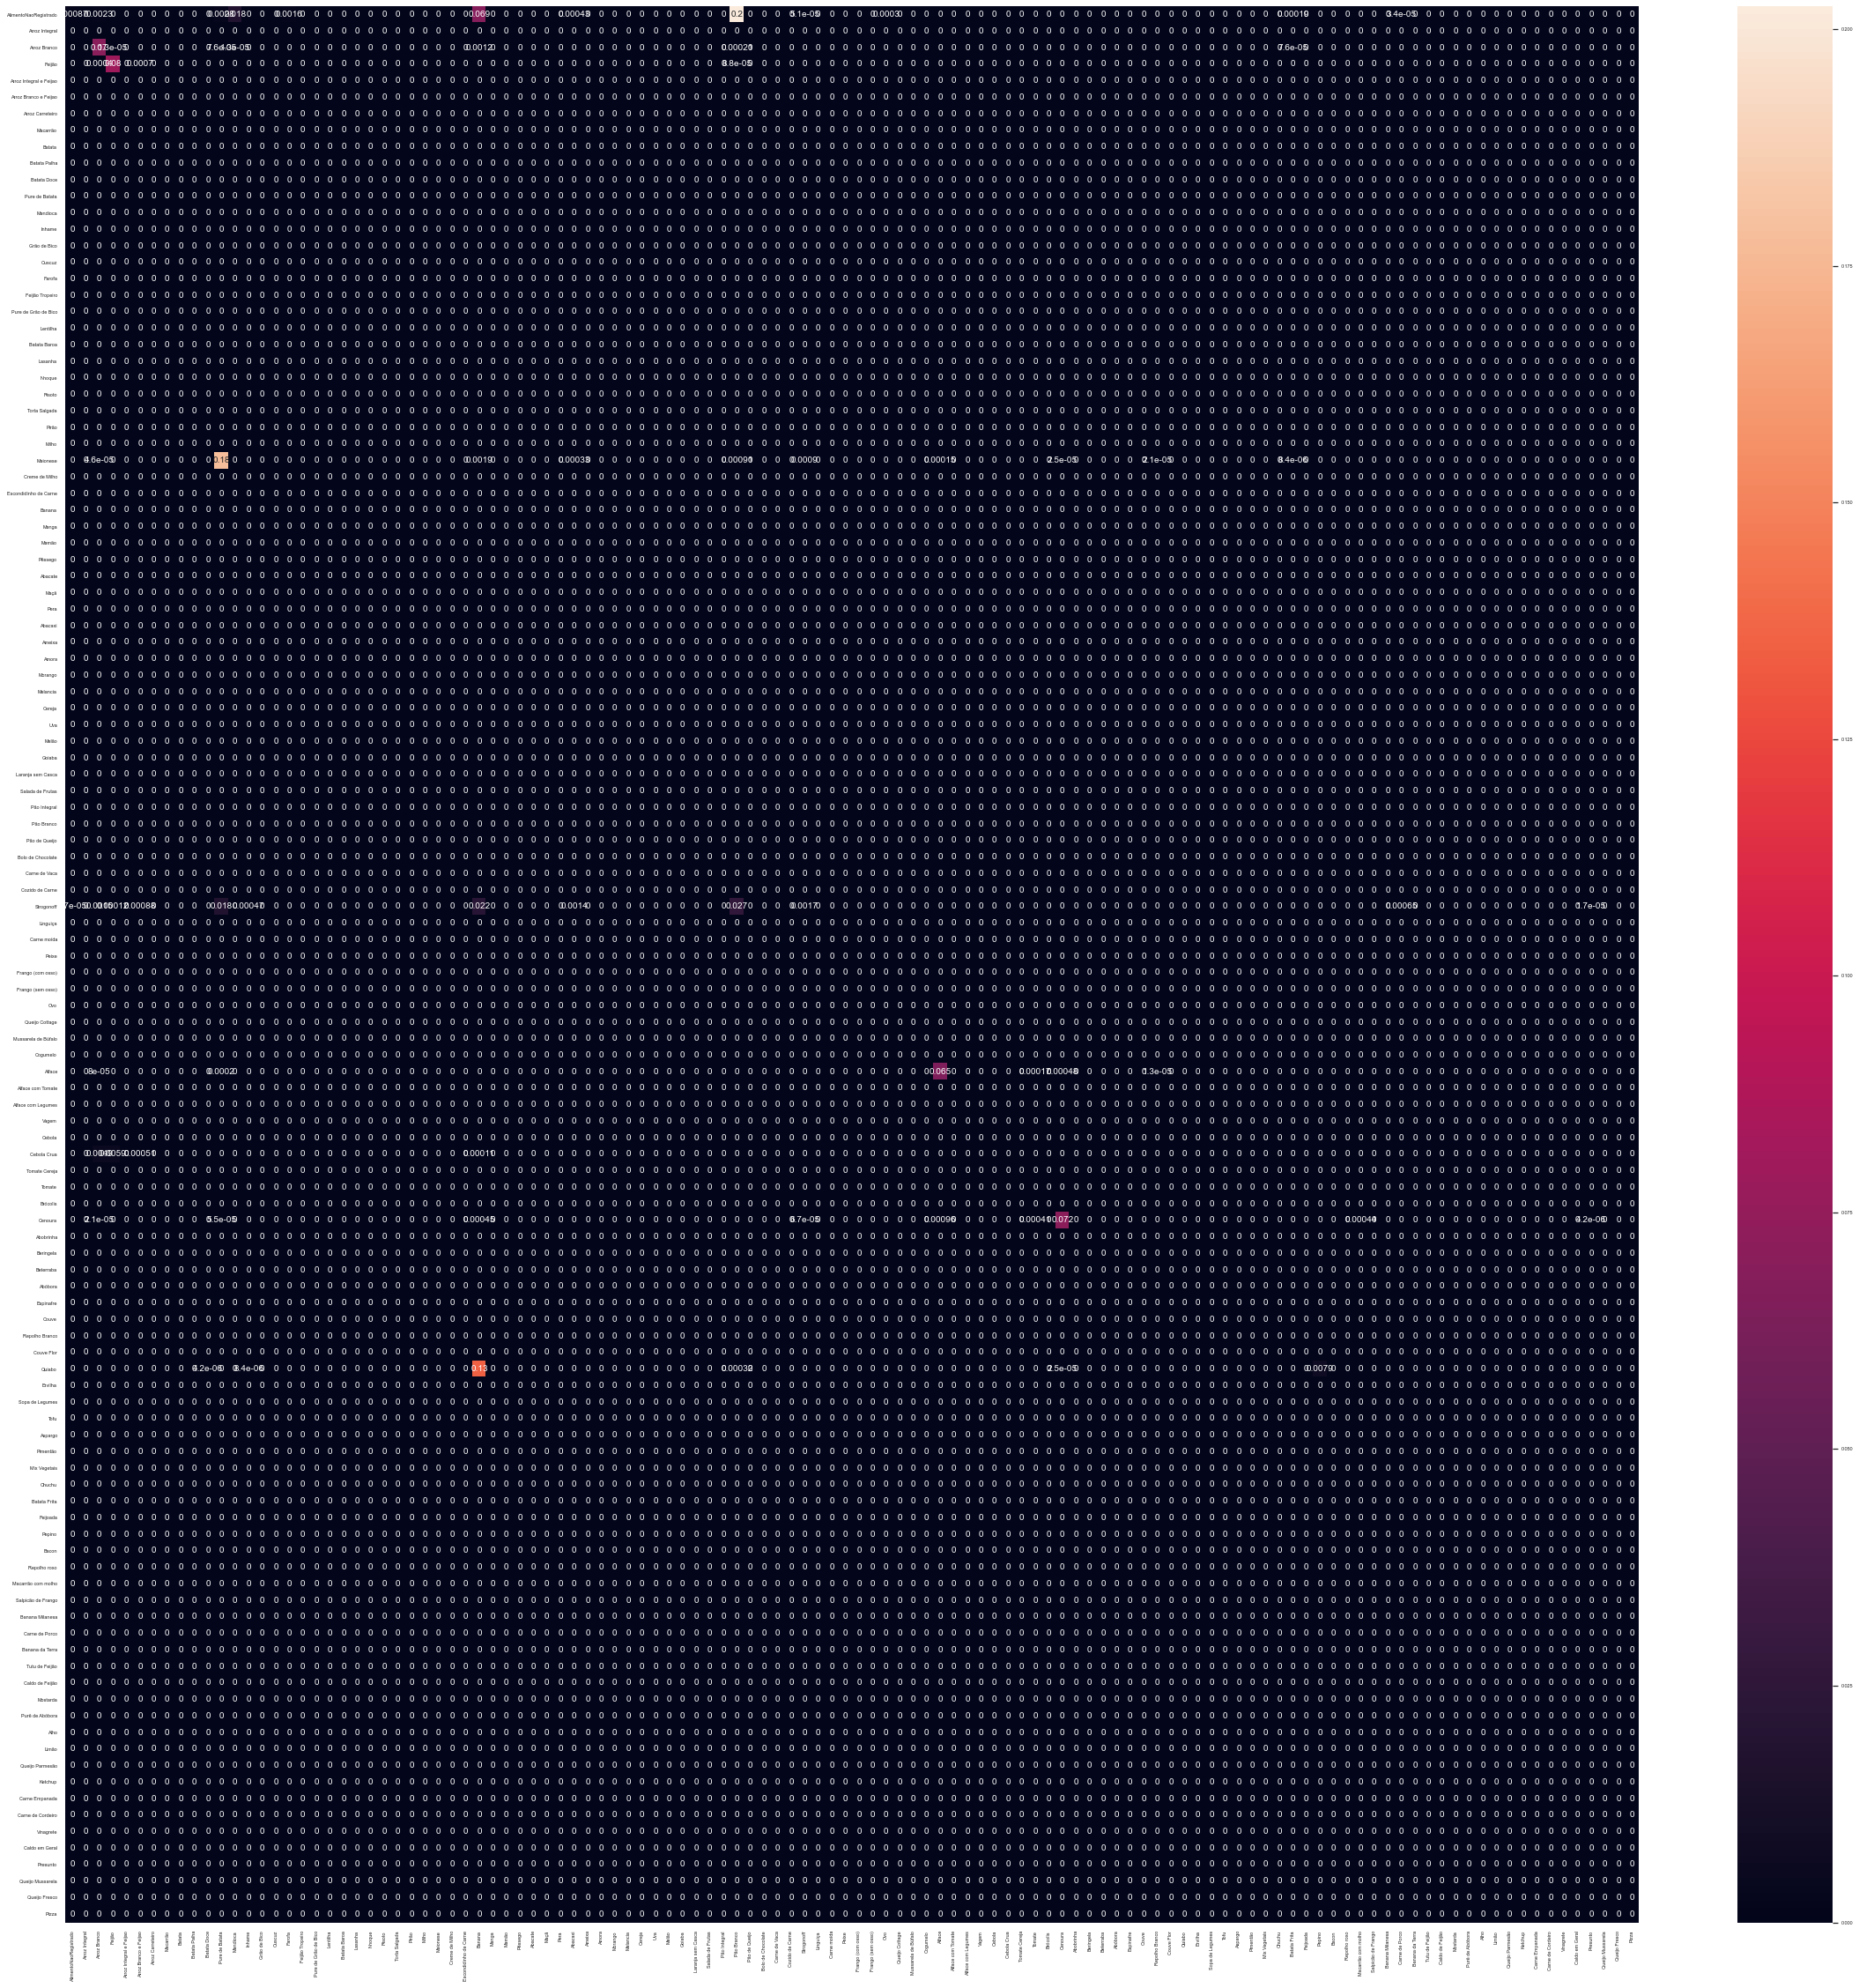

In [ ]:
#plot confusion matrix (take some time, too big the matrix). Think in a better way to visualize (check for most confuseds)

metricsObject.plotConfusionMatrix(confusionMatrix, codes)

In [ ]:
print(metricsObject.getClassificationReport(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

                         precision    recall  f1-score   support

  AlimentoNaoRegistrado       0.69      0.00      0.01     74982
         Arroz Integral       1.00      1.00      1.00         0
           Arroz Branco       0.85      0.97      0.91     17006
                 Feijão       0.91      0.98      0.94     19310
Arroz Integral e Feijao       1.00      1.00      1.00         0
  Arroz Branco e Feijao       0.00      1.00      0.00         0
       Arroz Carreteiro       1.00      1.00      1.00         0
               Macarrão       1.00      1.00      1.00         0
                 Batata       1.00      1.00      1.00         0
           Batata Palha       1.00      1.00      1.00         0
            Batata Doce       0.00      1.00      0.00         0
         Pure de Batata       0.00      1.00      0.00         0
               Mandioca       0.00      1.00      0.00         0
                 Inhame       0.00      1.00      0.00         0
           Grão de Bico 

## Check some particular image details

In [ ]:
from collections import OrderedDict

def getFoodsInImage(tensor, removeVoid=False):
    foods, counts = np.unique(tensor,return_counts=True)
    if removeVoid:
        counts = np.delete(counts, 0) #tira o void na posicao 0 do array
        foods = np.delete(foods, 0) #tira o void na posicao 0 do array
    
    foodNames = []
    print(f'Numero de alimentos: {len(foods)}')
    for food in foods:
        foodNames = np.append(foodNames,id2name[food])
    dictCounts = dict(zip(foodNames, counts))
    dictCounts = OrderedDict(sorted(dictCounts.items(), key=lambda x: x[1], reverse=True))
    print(dictCounts)
    return dictCounts

def getMostAppearances(foodCountsDict, k = 3):
    sortedDict = OrderedDict(sorted(foodCountsDict.items(), key=lambda x: x[1], reverse=True))
    topKDict = {}
    for count, (key, v) in enumerate(foodCountsDict.items()):
        if count == k:
            break
        elif key != "NaoAlimento":
            topKDict[key] = v
        else:
            k += 1 # increment k if find NaoAlimento in the first positions
    
    return topKDict
        


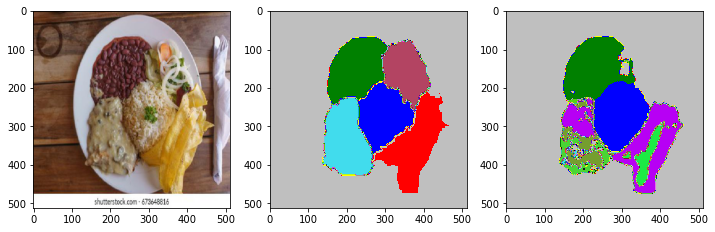

In [ ]:
idx = 0
fig = plt.figure(figsize=(12,12))

# denorm to original image
rawImage = input[idx]
nrm = Normalize.from_stats(*imagenet_stats)
image = nrm.decode(rawImage).clamp(0,1).squeeze().permute(1,2,0) # denorm image from imagenet stats

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(image)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(groundTruth[idx], cmap=cmap, norm=norm)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(decoded[idx], cmap=cmap, norm=norm)

In [ ]:
print("Ground truth\n")
sample = groundTruth[idx]
gtDictCounts = getFoodsInImage(sample)


Ground truth

Numero de alimentos: 6
OrderedDict([('NaoAlimento', 169307), ('AlimentoNaoRegistrado', 22992), ('Feijão', 19310), ('Strogonoff', 19310), ('Arroz Branco', 17006), ('Cebola Crua', 14219)])


In [ ]:
print("Prediction\n")
sample = decoded[idx]
decodedDictCounts = getFoodsInImage(sample)


Prediction

Numero de alimentos: 15
OrderedDict([('NaoAlimento', 183950), ('Banana', 21230), ('Feijão', 20712), ('Arroz Branco', 19162), ('Pão Branco', 6597), ('Pure de Batata', 4544), ('Mandioca', 4319), ('Arroz Branco e Feijao', 535), ('Strogonoff', 396), ('Abacaxi', 337), ('Carne de Porco', 154), ('Inhame', 112), ('Batata Frita', 76), ('AlimentoNaoRegistrado', 16), ('Presunto', 4)])


In [ ]:
# get low prob classes

bestProbs, bestProbsIdx = torch.max(probabilities[idx], dim=0)
lowProbs = []
lowProbsIdx = []

mask = bestProbs < 0.5
lowProbsIdx = bestProbsIdx[mask]
lowProbDictCounts = getFoodsInImage(lowProbsIdx)

print("\nPercentual de pixeis com baixa probabilidade\n")
for key, value in lowProbDictCounts.items():
    pct = float(value/decodedDictCounts[key]*100)
    print(key, '{:.2f}'.format(pct), "%" )

Numero de alimentos: 15
OrderedDict([('Banana', 12089), ('Pão Branco', 5688), ('NaoAlimento', 5118), ('Pure de Batata', 4544), ('Mandioca', 4319), ('Feijão', 1711), ('Arroz Branco', 955), ('Arroz Branco e Feijao', 509), ('Strogonoff', 396), ('Abacaxi', 337), ('Carne de Porco', 154), ('Inhame', 112), ('Batata Frita', 76), ('AlimentoNaoRegistrado', 16), ('Presunto', 4)])

Percentual de pixeis com baixa probabilidade

Banana 56.94 %
Pão Branco 86.22 %
NaoAlimento 2.78 %
Pure de Batata 100.00 %
Mandioca 100.00 %
Feijão 8.26 %
Arroz Branco 4.98 %
Arroz Branco e Feijao 95.14 %
Strogonoff 100.00 %
Abacaxi 100.00 %
Carne de Porco 100.00 %
Inhame 100.00 %
Batata Frita 100.00 %
AlimentoNaoRegistrado 100.00 %
Presunto 100.00 %


In [ ]:
# get high prob classes

bestProbs, bestProbsIdx = torch.max(probabilities[idx], dim=0)

mask = bestProbs > 0.5
highProbsIdx = bestProbsIdx[mask]
highProbDictCounts = getFoodsInImage(highProbsIdx)

print("\nPercentual de pixeis com alta probabilidade\n")
for key, value in highProbDictCounts.items():
    pct = float(value/decodedDictCounts[key]*100)
    print(key, '{:.2f}'.format(pct), "%" )

Numero de alimentos: 6
OrderedDict([('NaoAlimento', 178832), ('Feijão', 19001), ('Arroz Branco', 18207), ('Banana', 9141), ('Pão Branco', 909), ('Arroz Branco e Feijao', 26)])

Percentual de pixeis com alta probabilidade

NaoAlimento 97.22 %
Feijão 91.74 %
Arroz Branco 95.02 %
Banana 43.06 %
Pão Branco 13.78 %
Arroz Branco e Feijao 4.86 %


## Predictions of new input data

C:\Users\bruno\miniconda3\lib\site-packages\fastai\metrics.py:376: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
Numero de alimentos: 16
OrderedDict([('NaoAlimento', 160121), ('Pure de Batata', 47347), ('Arroz Branco', 32620), ('Macarrão', 8212), ('Batata Palha', 8155), ('Strogonoff', 3325), ('Repolho Branco', 1114), ('Feijão', 771), ('Arroz Branco e Feijao', 342), ('Alface', 70), ('Pão Branco', 26), ('Arroz Integral', 15), ('Abacaxi', 14), ('Batata Frita', 6), ('Risoto', 5), ('AlimentoNaoRegistrado', 1)])

3 principais alimentos: ['Pure de Batata', 'Arroz Branco', 'Macarrão']


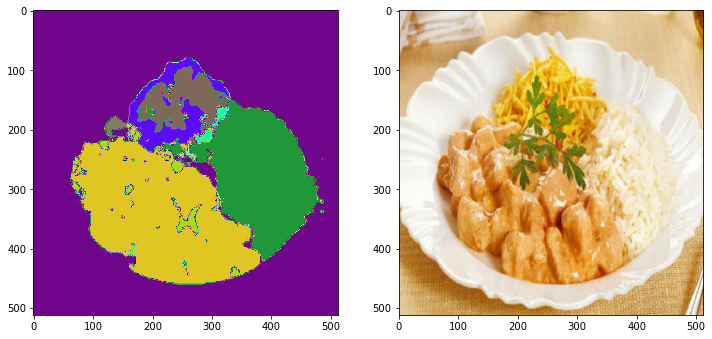

In [ ]:
#input should be a PIL object

index = 2
pred = learner.predict(dataloaders.valid_ds[index][0])

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(pred[0],cmap=cmap)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(dataloaders.valid_ds[index][0])

foods = getFoodsInImage(pred[0])
k = 3
mostAppear = list(getMostAppearances(foods, k=k).keys())
print('\n{} principais alimentos:'.format(k),mostAppear)